In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow
import librosa.display

In [16]:
song_name = f'../Project-for-machine-learning/archive/genres/blues/blues.00000.au'
y, sr = librosa.load(song_name, mono=True, duration=2, offset=0)
#The IDE is telling me that "feature" is old, but it isn't
#Newest library source: https://librosa.org/doc/0.10.2/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram
ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=128)
ps = librosa.power_to_db(ps**2)
ps.shape

(128, 173)

In [17]:
dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

for genre, genre_number in genres.items():
    for filename in os.listdir(f'../Project-for-machine-learning/archive/genres/{genre}'):
        song_name = f'../Project-for-machine-learning/archive/genres/{genre}/{filename}'
        for index in range(14):
            y, sr = librosa.load(song_name, mono=True, duration=2, offset=index*2)
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            dataset.append( (ps, genre_number) )

In [18]:
print(len(dataset))

14000


In [19]:
import random

random.shuffle(dataset)

train = dataset[:10000]
valid = dataset[10000:12000]
test = dataset[12000:]

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (64, 173, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (64, 173, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (64, 173, 1) ) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(tensorflow.keras.utils.to_categorical(Y_train, 10))
Y_valid = np.array(tensorflow.keras.utils.to_categorical(Y_valid, 10))
Y_test = np.array(tensorflow.keras.utils.to_categorical(Y_test, 10))

In [20]:
import tensorflow as tf


In [ ]:
!pip install transformers

In [22]:
from tensorflow.keras import Input

len(X_train)
X_train.shape
n_features = X_train.shape[2]
input_shape = (None, X_train.shape[1])
print(input_shape)
model_input = Input(input_shape, name='input')
print(model_input)
X_train.shape

(None, 64)
<KerasTensor shape=(None, None, 64), dtype=float32, sparse=False, name=input>


(10000, 64, 173, 1)

In [25]:
model = Sequential()
model.add(Conv2D(20, (5, 5), input_shape=(64, 173, 1),
                 activation="relu", strides=1, padding="valid"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(50, (5, 5), use_bias=50))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 60, 169, 20)    │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 84, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 80, 50)     │        25,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 40, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 26000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 26000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,656,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,684,396 (25.50 MB)

 Trainable params: 6,684,396 (25.50 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate = 1e-5), loss="categorical_crossentropy", metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
history = model.fit(X_train, Y_train, epochs=40, batch_size=64, validation_data= (X_test, Y_test), callbacks=[early_stopping])

# My pc can't run that many epochs (╥﹏╥)
# Hopefully I get a better one ( ◡̀_◡́)ᕤ

Epoch 1/90
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.1435 - loss: 13.3000 - val_accuracy: 0.3555 - val_loss: 3.2019
Epoch 2/90
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.2673 - loss: 6.4129 - val_accuracy: 0.4335 - val_loss: 2.4715
Epoch 3/90
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.3487 - loss: 4.3188 - val_accuracy: 0.4690 - val_loss: 2.1259
Epoch 4/90
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.3947 - loss: 3.2749 - val_accuracy: 0.4990 - val_loss: 1.9033
Epoch 5/90
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.4363 - loss: 2.6312 - val_accuracy: 0.5060 - val_loss: 1.8252
Epoch 6/90
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.4639 - loss: 2.3759 - val_accuracy: 0.5135 - val_loss: 1.7553
Epoch 7/90
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.4870 - loss: 2.1901 - val_accuracy: 0.5360 - val_loss: 1.6681
Epoch 8/90
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.5188 - loss: 1

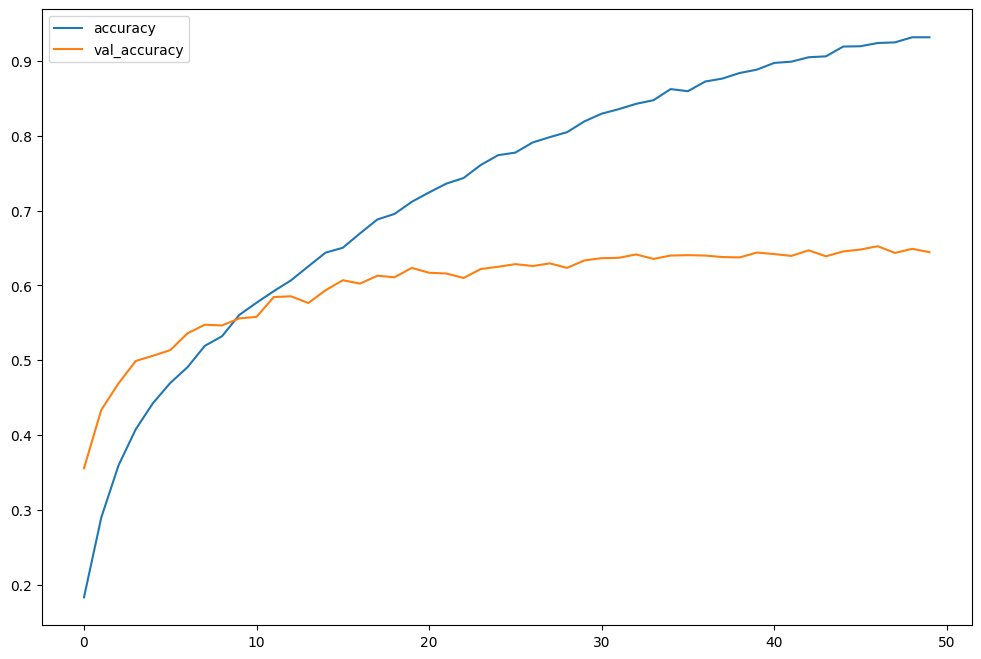

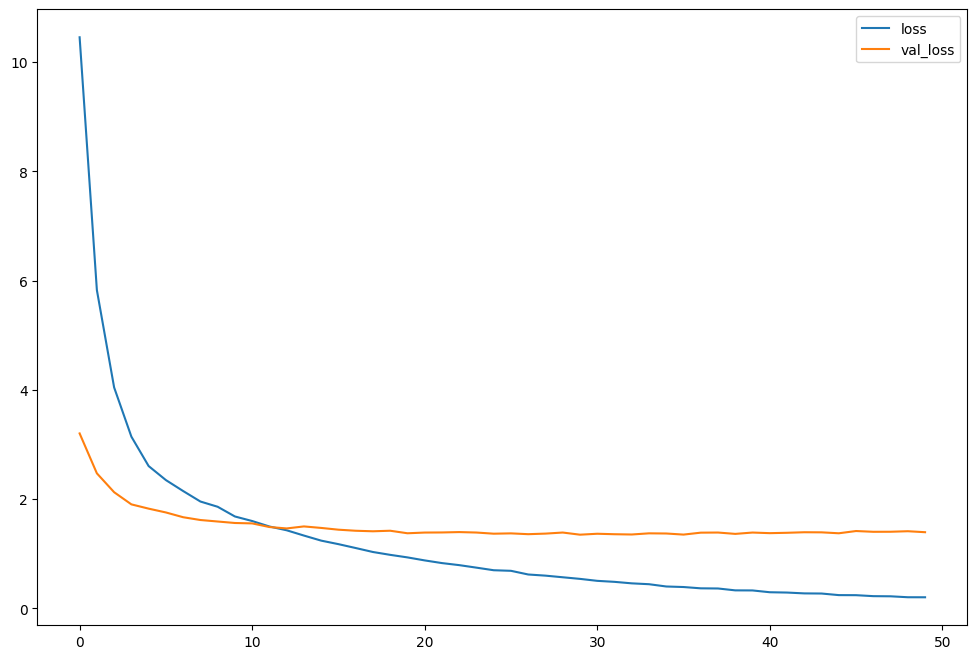

313/313 - 4s - 13ms/step - accuracy: 0.9956 - loss: 0.0402
63/63 - 1s - 13ms/step - accuracy: 0.6445 - loss: 1.3938
Training accuracy: 0.9955999851226807
Test accuracy: 0.6445000171661377


In [30]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose = 2)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose = 2)
print('Training accuracy:', train_acc)
print('Test accuracy:', test_acc)